In [11]:
!pip install opencv-python

You should consider upgrading via the '/Users/atharvasrivastava/Downloads/brain tumor detection project/wtf/bin/python3 -m pip install --upgrade pip' command.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

In [13]:
from glob import glob
from PIL import Image
from numpy import asarray

In [22]:
import os
dirct = '/Users/atharvasrivastava/Downloads/brain tumor detection project/'

In [ ]:
import os
path = os.path.join(dirct, 'Brain_Tumor_Data')
classes = {'no_tumor': 0, 'pituitary_tumor': 1}

In [24]:
no_tumor_frompath = os.path.join(path, 'Training', 'no_tumor')
no_tumor_topath = os.path.join(path, 'Agumented_Data', 'Training', 'no_tumor')
if not os.path.exists(no_tumor_frompath):
    raise FileNotFoundError(f"Source directory {no_tumor_frompath} does not exist. Please verify the path to your 'no_tumor' images.")
os.makedirs(no_tumor_topath, exist_ok=True)
no_tumor_images = glob(os.path.join(no_tumor_frompath, '*'))
if not no_tumor_images:
    print(f"Warning: No images found in {no_tumor_frompath}")
c = 0
for img_path in no_tumor_images:
    try:
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img.save(os.path.join(no_tumor_topath, f'{c}.jpg'))
        c += 1
        mirimg = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        mirimg.save(os.path.join(no_tumor_topath, f'{c}.jpg'))
        c += 1
        rotimg = img.rotate(90, Image.Resampling.NEAREST, expand=1)
        rotimg.save(os.path.join(no_tumor_topath, f'{c}.jpg'))
        c += 1
        mirrotimg = rotimg.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        mirrotimg.save(os.path.join(no_tumor_topath, f'{c}.jpg'))
        c += 1
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

In [25]:
frompath = os.path.join(path, 'Training', 'pituitary_tumor')
topath = os.path.join(path, 'Agumented_Data', 'Training', 'pituitary_tumor')
if not os.path.exists(frompath):
    raise FileNotFoundError(f"Source directory {frompath} does not exist. Please verify the path to your 'pituitary_tumor' images.")
os.makedirs(topath, exist_ok=True)
images = glob(os.path.join(frompath, '*'))
if not images:
    print(f"Warning: No images found in {frompath}")
c = 0
for img_path in images:
    try:
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img.save(os.path.join(topath, f'{c}.jpg'))
        c += 1
        mirimg = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        mirimg.save(os.path.join(topath, f'{c}.jpg'))
        c += 1
        rotimg = img.rotate(90, Image.Resampling.NEAREST, expand=1)
        rotimg.save(os.path.join(topath, f'{c}.jpg'))
        c += 1
        mirrotimg = rotimg.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        mirrotimg.save(os.path.join(topath, f'{c}.jpg'))
        c += 1
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

In [26]:
import cv2
X = []
Y = []
for cls in classes:
    pth = os.path.join(path, 'Agumented_Data', 'Training', cls)
    if not os.path.exists(pth):
        print(f"Warning: Directory {pth} does not exist. Skipping...")
        continue
    for j in os.listdir(pth):
        try:
            img = cv2.imread(os.path.join(pth, j))
            if img.shape != (224, 224, 3):
                img = cv2.resize(img, (224, 224))
            X.append(img)
            Y.append(classes[cls])
        except Exception as e:
            print(f"Error loading {j}: {e}")

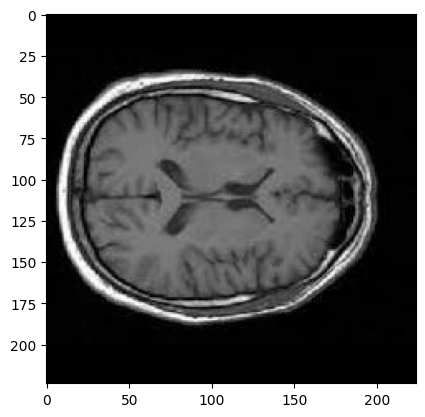

In [ ]:
if X: 
    plt.imshow(X[0])
    plt.show()
else:
    print("No images loaded to display.")

In [28]:
if X and Y:
    X = np.array(X)
    Y = np.array(Y)
    print(f"Loaded {len(X)} images.")
else:
    raise ValueError("No images were loaded into X or Y. Check previous steps.")

Loaded 4888 images.


In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [31]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [32]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [33]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [34]:
for layer in vgg.layers:
    layer.trainable = False

In [35]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def lw(custom_model, num_classes):
    x = custom_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(num_classes, activation='softmax')(x)
    return preds

In [36]:
num_classes = 2
FC_Head = lw(vgg, num_classes)
model = Model(inputs=vgg.input, outputs=FC_Head)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), verbose=1, initial_epoch=0)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.7891 - loss: 0.4630 - val_accuracy: 0.9734 - val_loss: 0.0873
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 609s 5s/step - accuracy: 0.9674 - loss: 0.0924 - val_accuracy: 0.9407 - val_loss: 0.1467
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 576s 5s/step - accuracy: 0.9713 - loss: 0.0864 - val_accuracy: 0.9765 - val_loss: 0.0650
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 551s 4s/step - accuracy: 0.9774 - loss: 0.0526 - val_accuracy: 0.9796 - val_loss: 0.0811
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - accuracy: 0.9853 - loss: 0.0454 - val_accuracy: 0.9601 - val_loss: 0.1063


In [39]:
import pickle
filename = 'brain_tumor_model.pkl'

In [40]:
pickle.dump(model, open(filename, 'wb'))

In [41]:

load_model = pickle.load(open(filename, 'rb'))

In [42]:
model.save("model.keras")

In [ ]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.weights.h5')

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model.weights.h5') 

In [45]:
predictions = loaded_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step


In [46]:
dec = {0: 'No Tumor', 1: 'Positive Tumor'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


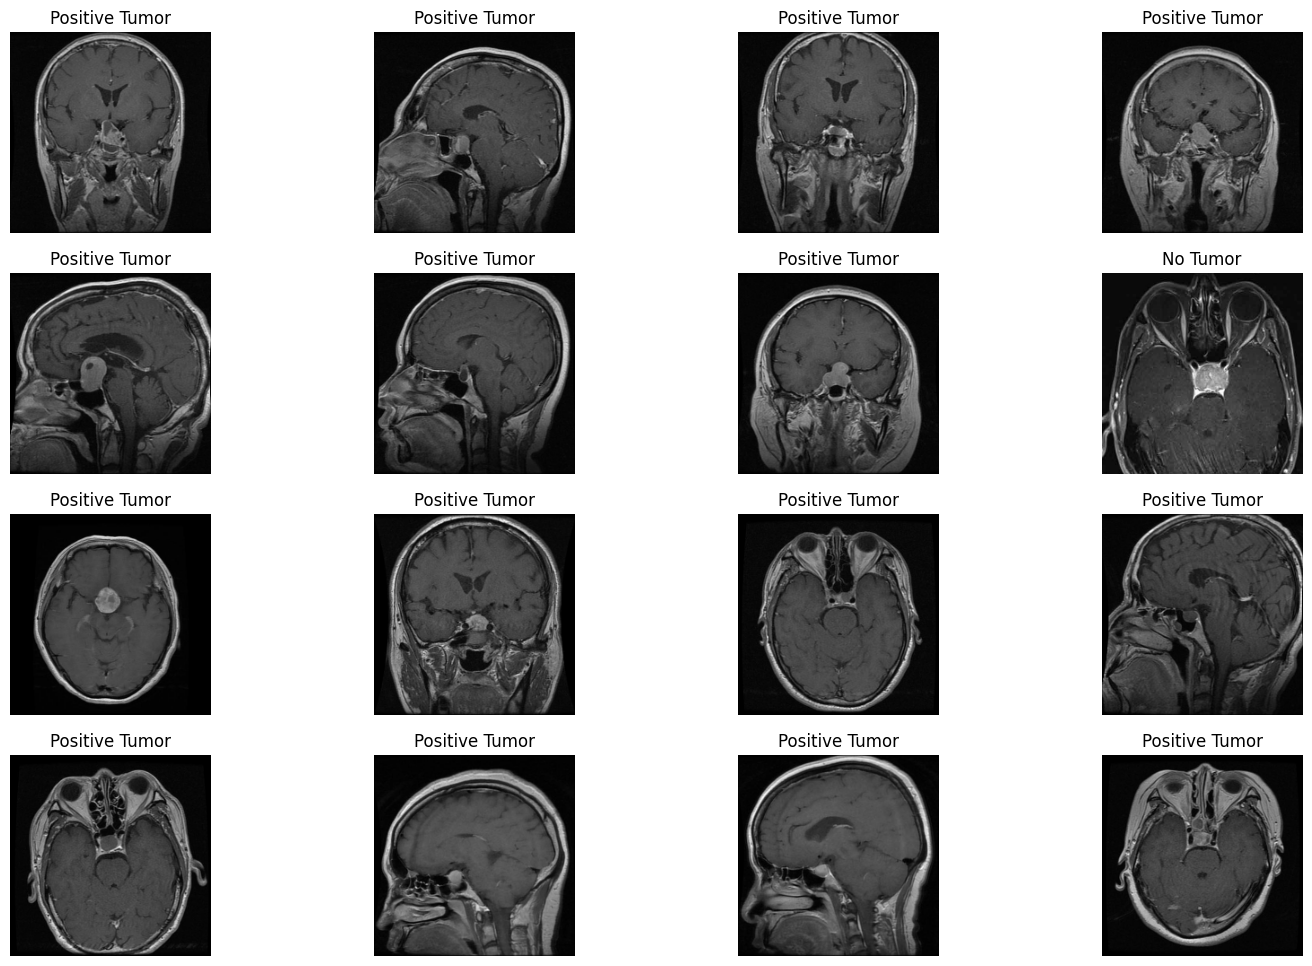

In [ ]:
plt.figure(figsize=(18, 12))
pituitary_dir = os.path.join(path, 'Training', 'pituitary_tumor')
if not os.path.exists(pituitary_dir):
    raise FileNotFoundError(f"Directory {pituitary_dir} does not exist.")
images = os.listdir(pituitary_dir)[:16]
predict_img = []
for i, img_name in enumerate(images, 1):
    img = cv2.imread(os.path.join(pituitary_dir, img_name))
    img = cv2.resize(img, (224, 224))  
    predict_img.append(img)
predict_img_uint8 = np.array(predict_img) 
predict_img = predict_img_uint8 / 255.0 
p = load_model.predict(predict_img)
result = np.argmax(p, axis=1)
for i, (img, res) in enumerate(zip(predict_img_uint8, result), 1): 
    plt.subplot(4, 4, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(dec[res])
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


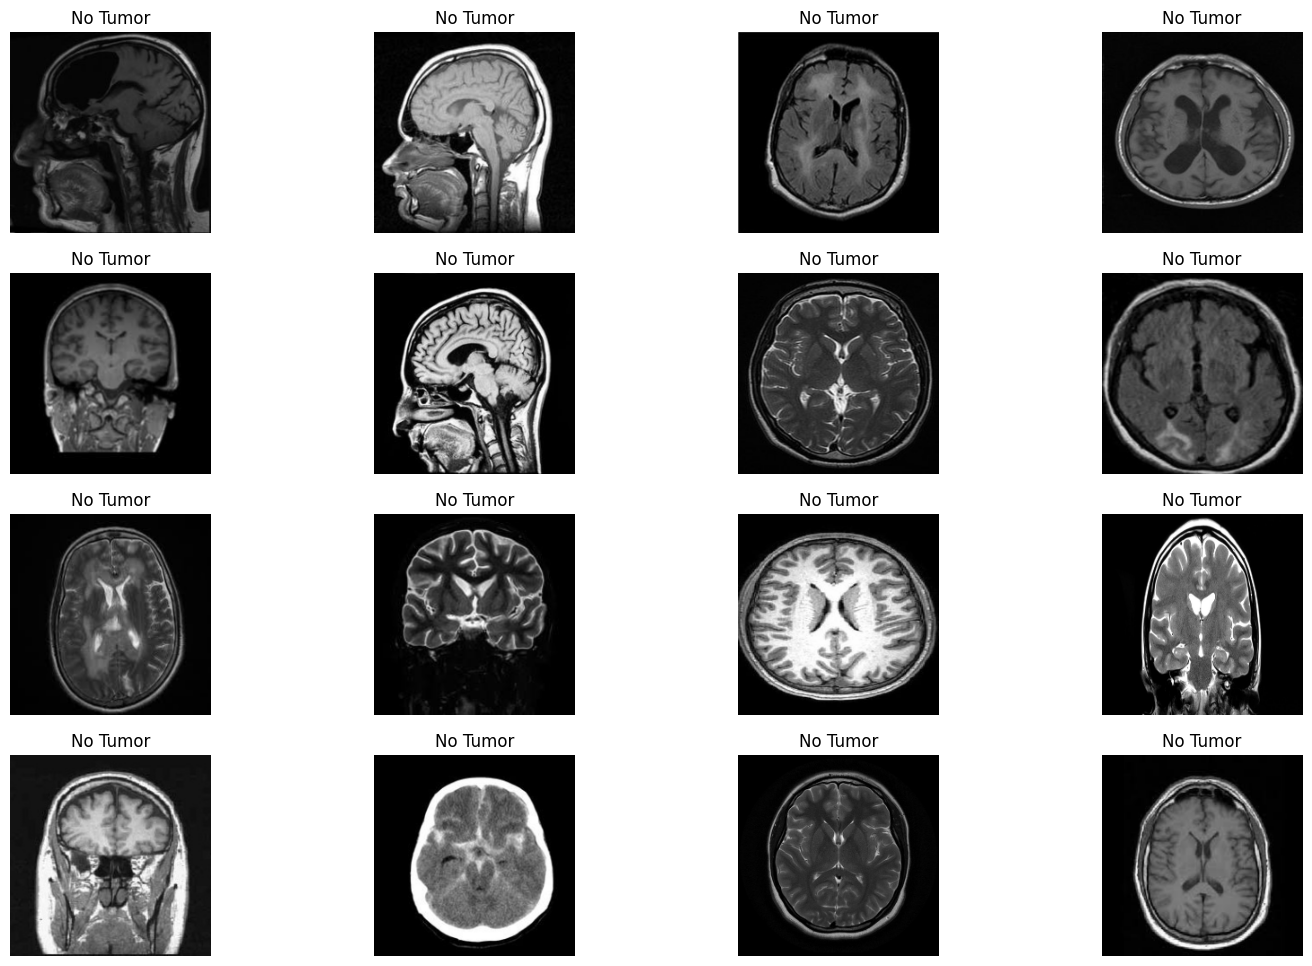

In [ ]:
plt.figure(figsize=(18, 12))
no_tumor_dir = os.path.join(path, 'Training', 'no_tumor')
if not os.path.exists(no_tumor_dir):
    raise FileNotFoundError(f"Directory {no_tumor_dir} does not exist.")
images = os.listdir(no_tumor_dir)[:16]
predict_img = []
for i, img_name in enumerate(images, 1):
    img = cv2.imread(os.path.join(no_tumor_dir, img_name))
    img = cv2.resize(img, (224, 224))
    predict_img.append(img)
predict_img_uint8 = np.array(predict_img)
predict_img = predict_img_uint8 / 255.0 
p = load_model.predict(predict_img)
result = np.argmax(p, axis=1)
for i, (img, res) in enumerate(zip(predict_img_uint8, result), 1): 
    plt.subplot(4, 4, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.title(dec[res])
    plt.axis('off')
plt.show()